# Elementy Inteligencji Obliczeniowej - Sieci Neuronowe


---

**Prowadzący:** Jakub Bednarek<br>
**Kontakt:** jakub.bednarek@put.poznan.pl<br>
**Materiały:** [Strona WWW](http://jakub.bednarek.pracownik.put.poznan.pl)

---

## Uwaga

* **Aby wykonać polecenia należy najpierw przejść do trybu 'playground'. File -> Open in Playground Mode**
* Nowe funkcje Colab pozwalają na autouzupełnianie oraz czytanie dokumentacji

## Cel ćwiczeń:
- zapoznanie się z Keras subclassing API
- stworzenie własnych modeli i warstw z wykorzystaniem Keras subclassing API
- wykorzystanie podstawowych mechanizmów regularyzacji: Dropout i Batch normalization

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Layer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta, RMSprop
from tensorflow.python.keras import backend as K
import functools
def pipe(*fns):
  return functools.reduce(lambda f, g: lambda x: f(g(x)), reversed(fns))


In [3]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[:, :, :, np.newaxis].astype('float32')
x_test = x_test[:, :, :, np.newaxis].astype('float32')
x_test /= 255
x_train /= 255
x_train_flat = x_train.reshape(60000, 784)
x_test_flat = x_test.reshape(10000, 784)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## Tworzenie własnych modeli i warstw 
https://www.tensorflow.org/tutorials/customization/custom_layers

https://www.tensorflow.org/guide/keras/custom_layers_and_models

Przykładowy model z warstwami gęstymi dla danych MNIST:

In [4]:

class DenseModel(Model):
  def __init__(self, num_classes=10):
    super().__init__(name='my_model')
    self.num_classes = num_classes
    self.dense_1 = Dense(512, input_shape=(784,), activation='relu')
    self.dense_2 = Dense(512, activation='relu')
    self.dense_3 = Dense(num_classes, activation='softmax')

  def call(self, inputs):
    return pipe(
      self.dense_1,
      self.dense_2,
      self.dense_3
    )(inputs)

model = DenseModel(num_classes=10)

In [5]:
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train_flat, y_train, batch_size=32, epochs=3)

Epoch 1/3
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
1875/1875 [==============================] - 11s 5ms/step - loss: 0.1863 - accuracy: 0.9438
Epoch 2/3
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0833 - accuracy: 0.9754
Epoch 3/3
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0617 - accuracy: 0.9826


Przykład własnej warstwy. Warstwa to po prostu funkcjonalny moduł do wielokrotnego używania, podczas gdy model to gotowe rozwiązanie dla danego problemu uczenia maszynowego (tzn. w Kerasie zazwyczaj kompletna sieć neuronowa), które udostępnia dodatkowo takie metody jak `fit`, `evaluate` i `predict`. Oczywiście można też budować modele/warstwy korzystające z innych modeli/warstw, API obu tych klas jest bardzo podobne.

W poniższym kodzie, metoda `build` w `CustomLayer` jest wołana raz przed pierwszym wywołaniem `call` (zaimplementowane jest to w `__call__()`), co pozwala nam uzależnić liczbę wag warstwy od wymiaru wyjść z warstwy poprzedniej. Jeżeli odgórnie wiemy, ile wag ma mieć warstwa, to równie dobrze możemy je zainicjować w `__init__` tak jak wcześniej.

In [6]:
class CustomLayer(Layer):
  def __init__(self, output_dim, **kwargs):
    self.output_dim = output_dim
    super(CustomLayer, self).__init__(**kwargs)

  def build(self, input_shape):
    # Create a trainable weight variable for this layer.
    self.kernel = self.add_weight(name='kernel',
                                  shape=(int(input_shape[1]), self.output_dim),
                                  initializer='uniform',
                                  trainable=True)

  def call(self, inputs):
    return tf.matmul(inputs, self.kernel)


class CustomModel(Model):

  def __init__(self, num_classes=10):
    super(CustomModel, self).__init__(name='custom_model')
    self.num_classes = num_classes
    # Define your layers here.
    self.dense_1 = CustomLayer(output_dim=512, input_shape=(784,))
    self.dense_2 = CustomLayer(output_dim=512, input_shape=(512,))
    self.dense_3 = CustomLayer(output_dim=num_classes, input_shape=(512,))

  def call(self, inputs):
    return pipe(
      self.dense_1,
      K.relu,
      self.dense_2,
      K.relu,
      self.dense_3,
      K.sigmoid
    )(inputs)

model = CustomModel(num_classes=10)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train_flat, y_train, batch_size=128, epochs=3)

Epoch 1/3
469/469 [==============================] - 4s 7ms/step - loss: 0.3179 - accuracy: 0.9025
Epoch 2/3
469/469 [==============================] - 3s 7ms/step - loss: 0.1007 - accuracy: 0.9696
Epoch 3/3
469/469 [==============================] - 3s 7ms/step - loss: 0.0640 - accuracy: 0.9802


### Zadanie 1
Na podstawie powyższego przykładu stwórz własny model kolejno składający się z:
- warstwy konwolucyjnej (Conv2D): 32 filtry 3x3,
- konwolucyjnej: 64 filtry 3x3,
- warstwy MaxPooling (MaxPooling2D): 2x2
- warstwy ukrytej gęstej (Dense): 128 neuronów,
- warstwy wyjściowej.

Ważne:
- w każdej warstwie poza warstwą wyjściową funkcją aktywacji powinno być relu,
- funkcja aktywacji dla warstwy wyjściowej to softmax,
- między częścią konwolucyjną a gęstą trzeba spłaszczyć tensor przy pomocy warstwy `Flatten`,
- w przykładzie jest wykorzystywana sieć gęsta (dane są spłaszczone), sieci z warstwami konwolucyjnymi muszą otrzymać tensor 4-wymiarowy, zakomentuj linie "spłaszczające" podczas wczytywania danych.
```
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
```

In [7]:
class CoolBeansModel(Model):
  def __init__(self, num_classes):
    super().__init__(name='MyModel')
    self.num_classes = num_classes
    self.conv_1 = Conv2D(32, (3, 3), activation='relu')
    self.conv_2 = Conv2D(64, (3, 3), activation='relu')
    self.pool_1 = MaxPooling2D()
    self.flatten = Flatten()
    self.dense_1 = Dense(128, activation='relu')
    self.dense_2 = Dense(num_classes, activation='softmax')

  def call(self, inputs):
    return pipe(
      self.conv_1,
      self.conv_2,
      self.pool_1,
      self.flatten,
      self.dense_1,
      self.dense_2
    )(inputs)

beans = CoolBeansModel(num_classes=10)
beans.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
beans_1_history = beans.fit(x_train, y_train, batch_size=32, epochs=4, validation_data=(x_test, y_test))

Epoch 1/4
1875/1875 [==============================] - 55s 29ms/step - loss: 0.1085 - accuracy: 0.9670 - val_loss: 0.0404 - val_accuracy: 0.9866
Epoch 2/4
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0360 - accuracy: 0.9887 - val_loss: 0.0415 - val_accuracy: 0.9883
Epoch 3/4
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0225 - accuracy: 0.9932 - val_loss: 0.0345 - val_accuracy: 0.9906
Epoch 4/4
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0155 - accuracy: 0.9953 - val_loss: 0.0334 - val_accuracy: 0.9903


### Zadanie 2 
Na podstawie powyższego przykładu stwórz model bloku ResNet:
- w warstwach konwolucyjnych wykorzystaj padding='same', aby rozmiary tensorów się nie zmieniały,
- tego modelu nie trzeba budować i uczyć, zostanie on wykorzystany w kolejnym zadaniu.

![resnet](https://miro.medium.com/max/1000/1*6HDuqhUzP92iXhHoS0Wl3w.png)

In [8]:
class ResBlock(Model):
  def __init__(self):
    super().__init__(name='ResBlock')
    self.conv_1 = Conv2D(64, (3, 3), padding='same', activation='relu')
    self.conv_2 = Conv2D(64, (3, 3), padding='same')

  def call(self, inputs):
    return pipe(
      self.conv_1,
      lambda x: x + inputs,
      self.conv_2,
      K.relu
    )(inputs)


### Zadanie 3
Zmodyfikuj model z zadania 1, zamieniając warstwy konwolucyjne na dwa modele bloku ResNet z zadania 2.

In [9]:
class ResNet(Model):
  def __init__(self, num_classes):
    super().__init__(name='ResNet')
    self.num_classes = num_classes
    self.res_1 = ResBlock()
    self.res_2 = ResBlock()
    self.pool_1 = MaxPooling2D()
    self.flatten = Flatten()
    self.dense_1 = Dense(128, activation='relu')
    self.dense_2 = Dense(num_classes, activation='softmax')

  def call(self, inputs):
    return pipe(
      self.res_1,
      self.res_2,
      self.pool_1,
      self.flatten,
      self.dense_1,
      self.dense_2
    )(inputs)


resnet = ResNet(num_classes=10)
resnet.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
resnet.fit(x_train, y_train, batch_size=32, epochs=4, validation_data=(x_test, y_test))

Epoch 1/4
1875/1875 [==============================] - 221s 117ms/step - loss: 0.1130 - accuracy: 0.9680 - val_loss: 0.0574 - val_accuracy: 0.9813
Epoch 2/4
1875/1875 [==============================] - 224s 120ms/step - loss: 0.0409 - accuracy: 0.9883 - val_loss: 0.0375 - val_accuracy: 0.9884
Epoch 3/4
1875/1875 [==============================] - 218s 116ms/step - loss: 0.0308 - accuracy: 0.9918 - val_loss: 0.0379 - val_accuracy: 0.9900
Epoch 4/4
1875/1875 [==============================] - 216s 115ms/step - loss: 0.0254 - accuracy: 0.9939 - val_loss: 0.0456 - val_accuracy: 0.9890


### Zadanie 4
Wykorzystując Keras Subclassing API, napisz Autoenkoder dla zbioru danych MNIST.
- stwórz osobny model Enkodera,
- stwórz osobny model Dekodera,
- połącz oba modele celem zbudowania Autoenkodera,
- można korzystać z warstw gęstych, nie trzeba korzystać z konwolucji,
- poprzednie zadania były przykładem klasyfikacji, w których wykorzystywana była funkcja błędu categorical_crossentropy (która jest stosowana dla wektorów reprezentujących rozkład prawdopodobieństwa), w przypadku Autoenkoderów model rekonstruuje dane wejściowe, więc najłatwiej wykorzystać mean square error (mse),
- w związku z powyższym również wyjście sieci się różni, nie klasyfikujemy (y_train) tylko rekonstruujemy (x_train)

https://blog.keras.io/building-autoencoders-in-keras.html

In [10]:
class Encoder(Model):
  def __init__(self):
    super().__init__(name='Encoder')
    self.dense_1 = Dense(128, activation='relu')
    self.dense_2 = Dense(64, activation='relu')
    self.dense_3 = Dense(32, activation='relu')

  def call(self, inputs):
    x = self.dense_1(inputs)
    x = self.dense_2(x)
    x = self.dense_3(x)
    return x

class Decoder(Model):
  def __init__(self):
    super().__init__(name='Decoder')
    self.dense_1 = Dense(64, activation='relu')
    self.dense_2 = Dense(128, activation='relu')
    self.dense_3 = Dense(784, activation='sigmoid')

  def call(self, inputs):
    return pipe(
      self.dense_1,
      self.dense_2,
      self.dense_3
    )(inputs)

class Autoencoder(Model):
  def __init__(self):
    super().__init__(name='Autoencoder')
    self.encoder = Encoder()
    self.decoder = Decoder()

  def call(self, inputs):
    return pipe(
      self.encoder,
      self.decoder,
    )(inputs)

autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x_train_flat, x_train_flat, batch_size=256, epochs=5, shuffle=True,
                validation_data=(x_test_flat, x_test_flat))

Epoch 1/5
235/235 [==============================] - 2s 4ms/step - loss: 0.0648 - val_loss: 0.0380
Epoch 2/5
235/235 [==============================] - 1s 4ms/step - loss: 0.0311 - val_loss: 0.0263
Epoch 3/5
235/235 [==============================] - 1s 4ms/step - loss: 0.0247 - val_loss: 0.0227
Epoch 4/5
235/235 [==============================] - 1s 4ms/step - loss: 0.0218 - val_loss: 0.0201
Epoch 5/5
235/235 [==============================] - 1s 4ms/step - loss: 0.0195 - val_loss: 0.0182


## Regularyzacja
### Zadanie 5
Rozszerz model stworzony w zadaniu 1 o dwie warstwy Dropout (Dropout - https://keras.io/api/layers/regularization_layers/dropout/):
- jedna po warstwie MaxPooling (wartość współczynnika odrzucenia 0.25)
- druga po gęstej warstwie ukrytej (Dense), wartość współczynnika odrzucenia 0.5.

  





In [11]:
class DumbdownCoolBeans(Model):
  def __init__(self, num_classes):
    super().__init__(name='DumbdownCoolBeans')
    self.num_classes = num_classes
    self.conv_1 = Conv2D(32, (3, 3), activation='relu')
    self.conv_2 = Conv2D(64, (3, 3), activation='relu')
    self.pool_1 = MaxPooling2D()
    self.dropout_1 = Dropout(0.25)
    self.flatten = Flatten()
    self.dense_1 = Dense(128, activation='relu')
    self.dropout_2 = Dropout(0.5)
    self.dense_2 = Dense(num_classes, activation='softmax')

  def call(self, inputs):
    return pipe(
      self.conv_1,
      self.conv_2,
      self.pool_1,
      self.dropout_1,
      self.flatten,
      self.dense_1,
      self.dropout_2,
      self.dense_2,
    )(inputs)

beans = DumbdownCoolBeans(num_classes=10)
beans.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
beans_2_history = beans.fit(x_train, y_train, batch_size=32, epochs=4, validation_data=(x_test, y_test))

Epoch 1/4
1875/1875 [==============================] - 50s 26ms/step - loss: 0.1930 - accuracy: 0.9412 - val_loss: 0.0501 - val_accuracy: 0.9843
Epoch 2/4
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0801 - accuracy: 0.9757 - val_loss: 0.0405 - val_accuracy: 0.9857
Epoch 3/4
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0688 - accuracy: 0.9808 - val_loss: 0.0433 - val_accuracy: 0.9861
Epoch 4/4
1875/1875 [==============================] - 50s 27ms/step - loss: 0.0649 - accuracy: 0.9812 - val_loss: 0.0411 - val_accuracy: 0.9877


### Zadanie 6
Rozszerz model stworzony w zadaniu 1 o dwie warstwy Batch normalization (BatchNormalization - https://keras.io/layers/normalization/) po warstwach konwolucyjnych.

In [12]:
class NormalizingCoolBeans(Model):
  def __init__(self, num_classes):
    super().__init__(name='NormalizingCoolBeans')
    self.num_classes = num_classes
    self.conv_1 = Conv2D(32, (3, 3), activation='relu')
    self.batch_norm_1 = BatchNormalization()
    self.conv_2 = Conv2D(64, (3, 3), activation='relu')
    self.batch_norm_2 = BatchNormalization()
    self.pool_1 = MaxPooling2D()
    self.flatten = Flatten()
    self.dense_1 = Dense(128, activation='relu')
    self.dense_2 = Dense(num_classes, activation='softmax')

  def call(self, inputs):
    return pipe(
      self.conv_1,
      self.batch_norm_1,
      self.conv_2,
      self.batch_norm_2,
      self.pool_1,
      self.flatten,
      self.dense_1,
      self.dense_2
    )(inputs)

beans = NormalizingCoolBeans(num_classes=10)
beans.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
beans_3_history = beans.fit(x_train, y_train, batch_size=32, epochs=4, validation_data=(x_test, y_test))


Epoch 1/4
1875/1875 [==============================] - 60s 32ms/step - loss: 0.2025 - accuracy: 0.9587 - val_loss: 0.1791 - val_accuracy: 0.9521
Epoch 2/4
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0745 - accuracy: 0.9847 - val_loss: 0.0993 - val_accuracy: 0.9812
Epoch 3/4
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0476 - accuracy: 0.9895 - val_loss: 0.0566 - val_accuracy: 0.9870
Epoch 4/4
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0309 - accuracy: 0.9926 - val_loss: 0.0618 - val_accuracy: 0.9869


### Zadanie 7
Rozszerz model stworzony w zadaniu 1 o warstwy z zadań 5 i 6.

In [14]:
class DumbdownNormalizingCoolBeans(Model):
  def __init__(self, num_classes):
    super().__init__(name='MyModelRegBatchNorm')
    self.num_classes = num_classes
    self.conv_1 = Conv2D(32, (3, 3), activation='relu')
    self.batch_norm_1 = BatchNormalization()
    self.conv_2 = Conv2D(64, (3, 3), activation='relu')
    self.batch_norm_2 = BatchNormalization()
    self.pool_1 = MaxPooling2D()
    self.dropout_1 = Dropout(0.25)
    self.flatten = Flatten()
    self.dense_1 = Dense(128, activation='relu')
    self.dropout_2 = Dropout(0.5)
    self.dense_2 = Dense(num_classes, activation='softmax')


  def call(self, inputs):
    return pipe(
      self.conv_1,
      self.batch_norm_1,
      self.conv_2,
      self.batch_norm_2,
      self.pool_1,
      self.dropout_1,
      self.flatten,
      self.dense_1,
      self.dropout_2,
      self.dense_2,
    )(inputs)

beans = DumbdownNormalizingCoolBeans(num_classes=10)
beans.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
beans_4_history = beans.fit(x_train, y_train, batch_size=32, epochs=4, validation_data=(x_test, y_test))

Epoch 1/4
1875/1875 [==============================] - 61s 32ms/step - loss: 0.3983 - accuracy: 0.9180 - val_loss: 0.0810 - val_accuracy: 0.9795
Epoch 2/4
1875/1875 [==============================] - 61s 33ms/step - loss: 0.2090 - accuracy: 0.9563 - val_loss: 0.3346 - val_accuracy: 0.9682
Epoch 3/4
1875/1875 [==============================] - 60s 32ms/step - loss: 0.1767 - accuracy: 0.9622 - val_loss: 0.1302 - val_accuracy: 0.9811
Epoch 4/4
1875/1875 [==============================] - 62s 33ms/step - loss: 0.1544 - accuracy: 0.9662 - val_loss: 0.0851 - val_accuracy: 0.9845


### Zadanie 8 
Porównaj modele stworzone w zadaniach 1, 5, 6, 7 na zbiorze danych MNIST. Stwórz wykresy z przebiegiem błędu funkcji celu i trafności klasyfikacji dla zbioru treningowego i walidacyjnego.
Cztery wykresy:
- błąd funkcji celu dla zbioru treningowego,
- błąd funkcji celu dla zbioru walidacyjnego,
- trafność klasyfikacji dla zbioru treningowego,
- trafność klasyfikacji dla zbioru walidacyjnego

Na każdym wykresie powinny być 4 przebiegi dla modeli z wszystkich zadań (1, 5, 6, 7), tak by łatwo można je było ze sobą wizualnie porównać.


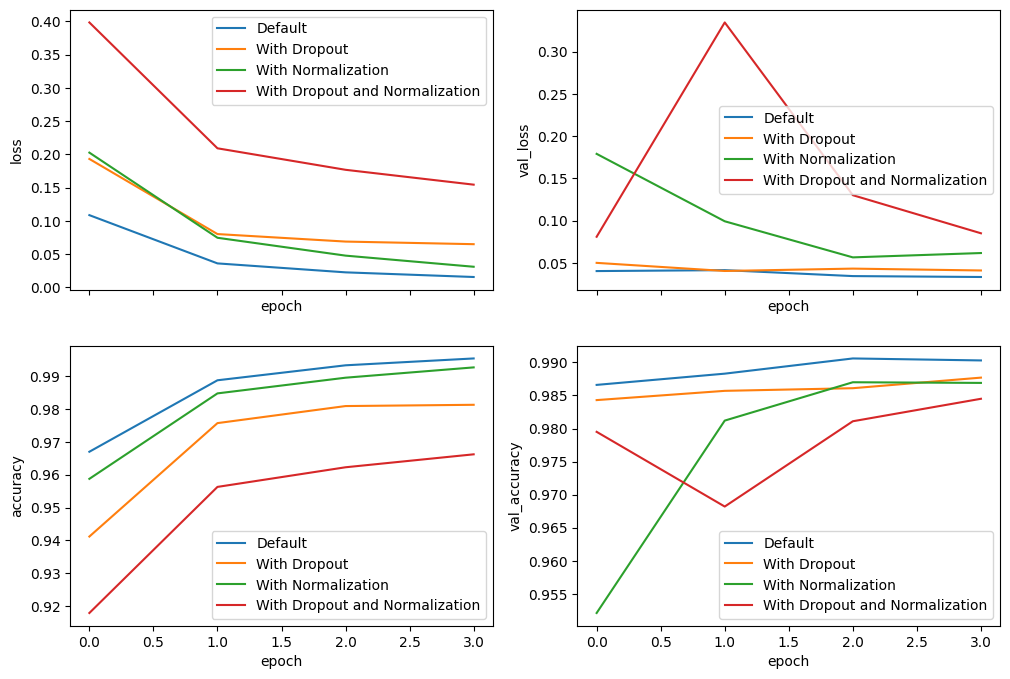

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True)

params = 'loss', 'val_loss', 'accuracy', 'val_accuracy'
for (axis, parameter) in zip(axes.reshape(-1), params):
  axis.plot(beans_1_history.history[parameter])
  axis.plot(beans_2_history.history[parameter])
  axis.plot(beans_3_history.history[parameter])
  axis.plot(beans_4_history.history[parameter])
  axis.set_ylabel(parameter)
  axis.set_xlabel('epoch')
  axis.legend(
    ['Default', 'With Dropout', 'With Normalization', 'With Dropout and Normalization'],
  )

plt.show()